In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import tqdm

import cv2

print(cv2.__version__)

4.4.0


# Carregando o dataset CIFAR10
### Atenção: O código faz o download de um arquivo grande



In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


# Inspecionando os dados

Para entender melhor a forma como os dados estão organizados, é feita uma extração de algumas amostras do dataset e as imagens são exibidas

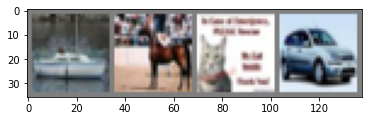

 ship horse   cat   car


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def to_np_img(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

def tensor_to_np(img):
    img = (img / 2 + 0.5) * 255     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (0, 2, 3, 1)) 
    return npimg.astype('uint8')


def imshow(img):
    plt.imshow(to_np_img(img))
    plt.show()
    
def print_confusion_matrix(confusion, figsize=(20,10)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + classes)
    ax.set_yticklabels([''] + classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Criação de um classificador usando Bag Of Features

As funções abaixo são responsáveis por executar os passos que compõem o método. São eles:

<ol>
  <li> Extração de features de baixo nível
  <li> Criação do dicionário visual
  <li> Representação da imagem em um histograma
  <li> Treinamento de um classificador baseado nas representações geradas
</ol>



## Extração de features de baixo nível


Para a extração de features de baixo nível primeiro está sendo feita uma amostragem das imagens através de um grid regular para a geração de keypoints. Para cada keypoint é obtido um descritor SIFT.

In [4]:
def build_keypoint_grid(spacing=5, verbose=False):
    keypoints = []
    for x in np.linspace(5, 27, num=spacing):
        for y in np.linspace(5, 27, num=spacing):
            keypoints.append([int(x),int(y)])
            
    if verbose:
        print(keypoints)
        
    keypoints = [cv2.KeyPoint(x[1], x[0], 1) for x in keypoints]
    return keypoints
    
    
def features_from_keypoints(images, keypoints, flatten=False):
    key_point_det = cv2.SIFT_create()
    features = []
    for i in range(len(images)):
        kp_target, des_target = key_point_det.compute(images[i], keypoints, None)
        features.append(des_target)
    features = np.array(features)
    if flatten:
        features = features.reshape(-1, 128)
    return features


def extract_lowlevel_features(loader):
    features = np.array([]).reshape(0,128)
    for i, data in enumerate(tqdm.tqdm(loader)):
        images = data[0]
        unnorm_images =  tensor_to_np(images)
        out = features_from_keypoints(unnorm_images, build_keypoint_grid(), flatten=True)
        features = np.vstack([features, out])
    print(features.shape)
    return features


# Extracting from images samples too create a dictionary...
visual_words = extract_lowlevel_features(trainloader)


100%|██████████| 782/782 [01:29<00:00,  8.70it/s]

(1250000, 128)


In [5]:
visual_words.shape

(1250000, 128)

## Criação do dicionário visual

Uma vez extraida as features de baixo nível, crio através de agrupamento um dicionário de "palavras visuais". Para a criação do dicionário estou utilizando um vocabulário de 100 palavras.

In [6]:

def build_visual_dictionary(features, size=50):
    kmeans = KMeans(n_clusters=size, random_state=0, verbose=0)
    kmeans.fit(features[0:50000])
    return kmeans
    


# Building the dictionary...
dictionaries = {}
for s in [50, 100]:
    print("Criando dicionário de tamanho {}".format(s))
    dictionaries[s] = build_visual_dictionary(visual_words, size=s)

Criando dicionário de tamanho 50
Criando dicionário de tamanho 100


## Criação da representação das imagens

Uma vez definido o dicionário, busco/descrevo novamente keypoints na imagem e gero um histograma com as palavras visuais encontradas. O histograma é a representação da imagem.

In [7]:
def extract_image_features(model, loader, size=50):
    features = np.array([]).reshape(0, size)
    all_labels = []
    for i, data in enumerate(tqdm.tqdm(loader)):
        images = data[0]
        labels = data[1].numpy()
        unnorm_images =  tensor_to_np(images)
        out = features_from_keypoints(unnorm_images, build_keypoint_grid(spacing=10))
        for i in range(len(out)):
            sample = out[i]
            prediction = model.predict(sample.astype(np.float64))
            hist, _ = np.histogram(prediction, bins=np.arange(size+1), density=True)
            hist = np.array(hist)
            features = np.vstack([features, hist])
            all_labels.append(labels[i])
            
    all_labels = np.array(all_labels)
    print(features.shape)
    print(all_labels.shape)
    return features, all_labels




# Extracting features for training...
training_features, training_labels = extract_image_features(dictionaries[50], trainloader, size=50)

# Extracting features for testing...
testing_features, testing_labels = extract_image_features(dictionaries[50], testloader, size=50)




  0%|          | 0/157 [00:00<?, ?it/s]

(50000, 50)
(50000,)


100%|██████████| 157/157 [00:12<00:00, 12.83it/s]

(10000, 50)
(10000,)


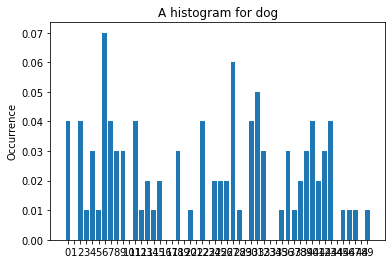

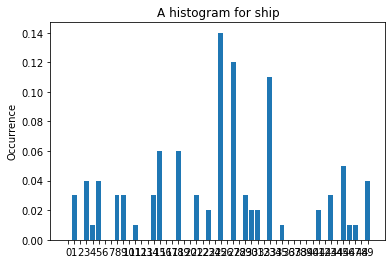

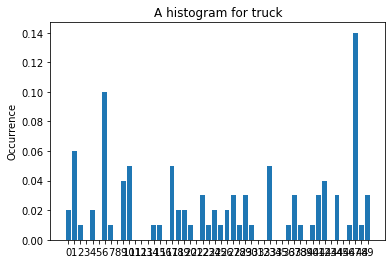

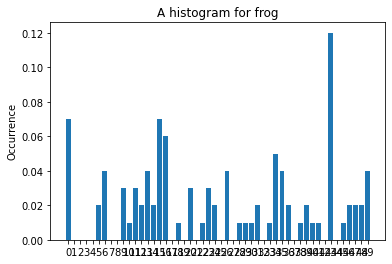

In [8]:
def print_histogram(hist, label, size=50):
    x = np.arange(size)  # the label location
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, hist)

    ax.set_ylabel('Occurrence')
    ax.set_title('A histogram for {}'.format(label))
    ax.set_xticks(x)
    plt.show()

print_histogram(training_features[1], classes[training_labels[1]])
print_histogram(training_features[2], classes[training_labels[2]])
print_histogram(training_features[3], classes[training_labels[3]])
print_histogram(training_features[4], classes[training_labels[4]])

## Treinamento de um classificador

Extraídas as representações de treino e teste, treino uma árvore de decisão para a geração da classificação final. Limitei a árvore de decisão para o tamanho máximo de quinze níveis para evitar overfitting.

In [9]:
# Build a classifiers
clf = tree.DecisionTreeClassifier(max_depth=10)
clf = clf.fit(training_features, training_labels)

## Resultados com Bag Of Features

Abaixo vemos os resultados expressos através de uma matriz de confusão

Acurácia no treino: 0.3257


<ipython-input-3-c4f26976e02f>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + classes)
<ipython-input-3-c4f26976e02f>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + classes)


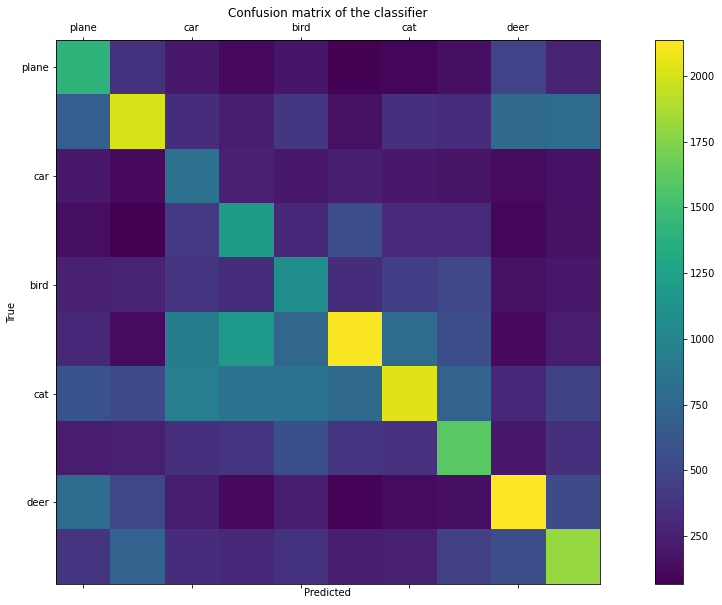

In [10]:
accuracy = ((clf.predict(training_features) == training_labels).sum())/len(training_labels)
print('Acurácia no treino: {}'.format(accuracy))

train_confusion = confusion_matrix(clf.predict(training_features), training_labels)
print_confusion_matrix(train_confusion)

Acurácia no teste: 0.2403


<ipython-input-3-c4f26976e02f>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + classes)
<ipython-input-3-c4f26976e02f>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + classes)


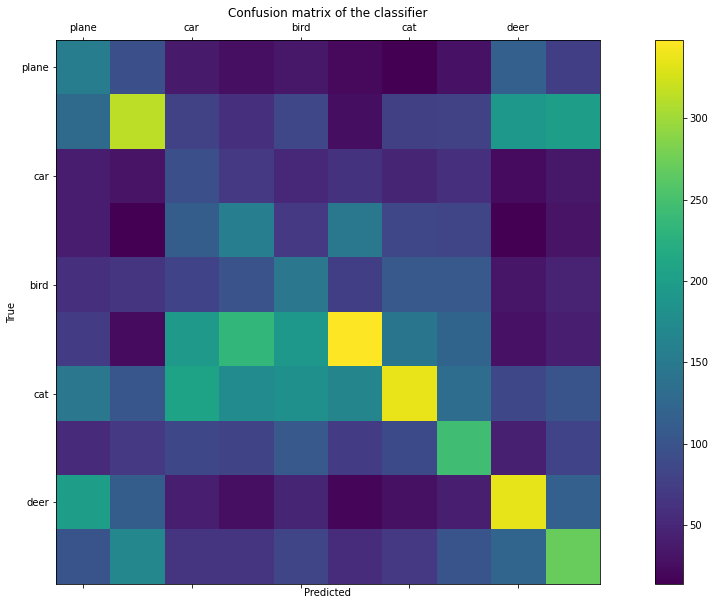

In [11]:
accuracy = ((clf.predict(testing_features) == testing_labels).sum())/len(testing_labels)
print('Acurácia no teste: {}'.format(accuracy))

test_confusion = confusion_matrix(clf.predict(testing_features), testing_labels)
print_confusion_matrix(test_confusion)

# Criação de um classificador utilizando uma rede convolucional

Para restar o resultado usando uma rede convolucional, estamos utilizando um modelo construido baseado na arquitetura LeNet5.

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Treinamento

Para o treinamento são executadas 10 épocas.

cuda:0
[1,   350] loss: 0.394
[1,   700] loss: 0.358


<ipython-input-3-c4f26976e02f>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + classes)
<ipython-input-3-c4f26976e02f>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + classes)


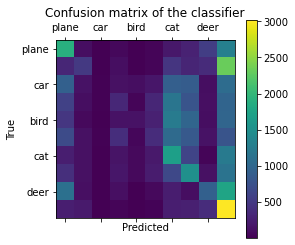

[2,   350] loss: 0.321
[2,   700] loss: 0.303


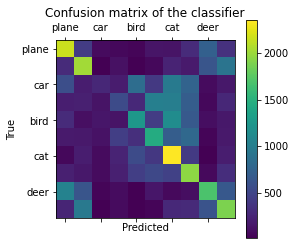

[3,   350] loss: 0.288
[3,   700] loss: 0.280


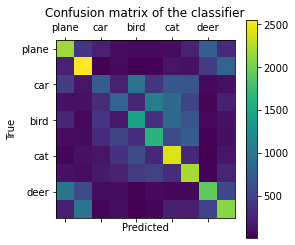

[4,   350] loss: 0.271
[4,   700] loss: 0.266


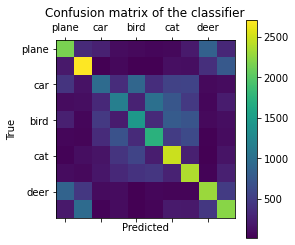

[5,   350] loss: 0.260
[5,   700] loss: 0.255


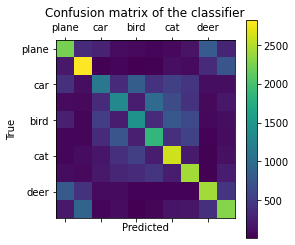

[6,   350] loss: 0.251
[6,   700] loss: 0.248


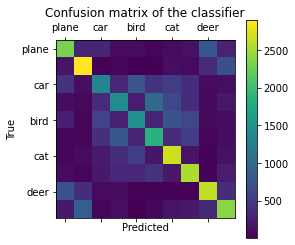

[7,   350] loss: 0.243
[7,   700] loss: 0.239


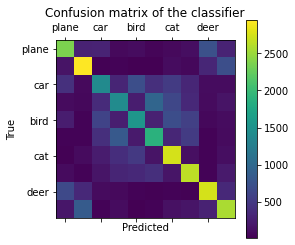

[8,   350] loss: 0.235
[8,   700] loss: 0.233


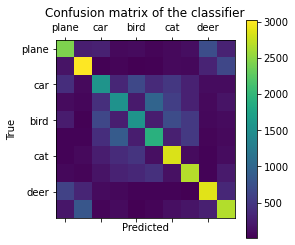

[9,   350] loss: 0.228
[9,   700] loss: 0.226


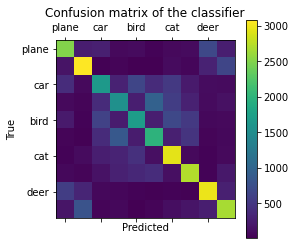

[10,   350] loss: 0.223
[10,   700] loss: 0.221


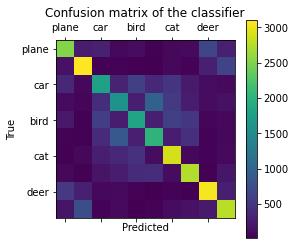

Finished Training


In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    train_confusion = np.zeros((10,10))
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        _, predicted = torch.max(outputs.data, 1)
        s = confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy(), labels=range(10))
        train_confusion = train_confusion + np.array(s)
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 350 == 349:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
        if i % 700 == 699:
            print_confusion_matrix(train_confusion, figsize=(4,4))

print('Finished Training')

## Resultados

Os resultados podem ser vistos abaixo. Primeiramente amostro algumas imagens do conjunto de testes e faço a classificação.

Em seguida, testo o modelo contra todo o conjunto de teste para obter a acurácia final do modelo.


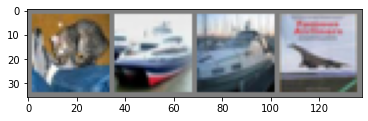

GroundTruth:    cat  ship  ship plane


In [15]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[0:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Matriz de confusão final de treino

Acurácia no treino: 0.56076


<ipython-input-3-c4f26976e02f>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + classes)
<ipython-input-3-c4f26976e02f>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + classes)


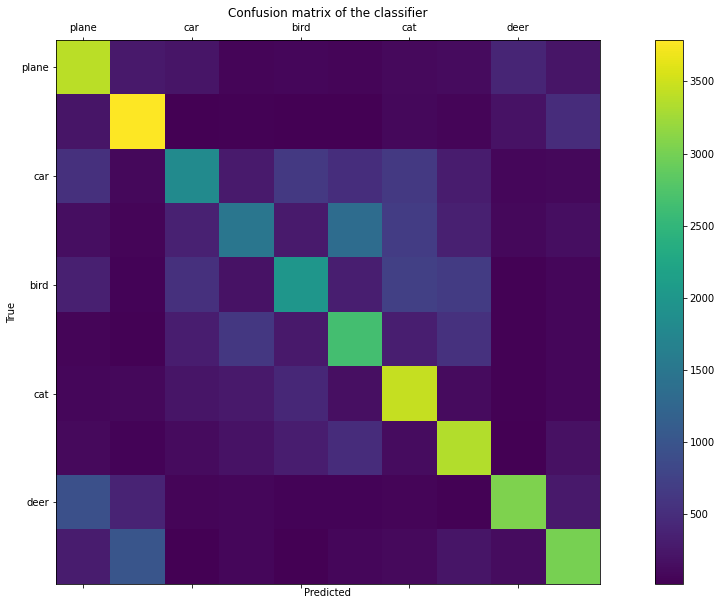

In [16]:
correct = 0
total = 0
train_confusion = np.zeros((10,10))
with torch.no_grad():
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        s = confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy(), labels=range(10))
        train_confusion = train_confusion + np.array(s)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Acurácia no treino: {}'.format(correct / total))

print_confusion_matrix(train_confusion)

## Acurácia e matriz de confusão no teste

Acurácia no teste: 0.5493


<ipython-input-3-c4f26976e02f>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + classes)
<ipython-input-3-c4f26976e02f>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + classes)


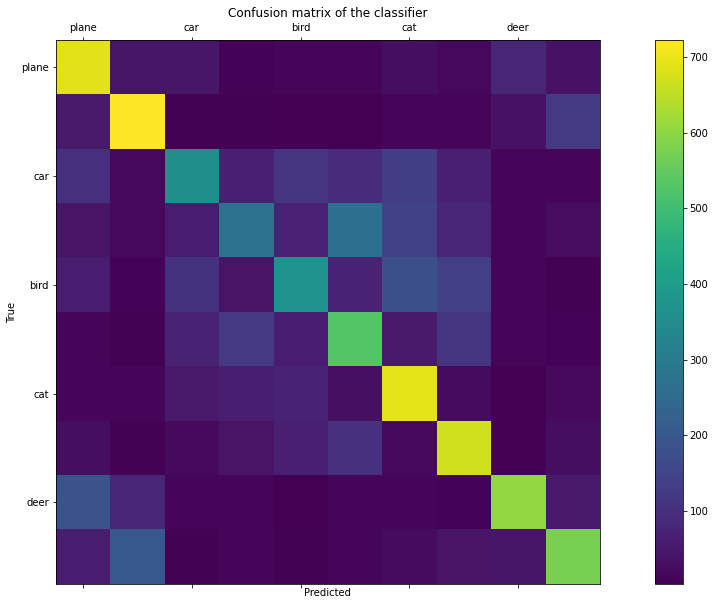

In [17]:
correct = 0
total = 0
test_confusion = np.zeros((10,10))
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        s = confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy(), labels=range(10))
        test_confusion = test_confusion + np.array(s)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Acurácia no teste: {}'.format(correct / total))

print_confusion_matrix(test_confusion)